<a href="https://colab.research.google.com/github/noufabdullahal/T5/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LISA Traffic Light Dataset**

In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

# Load data from CSV files
df_bulb = pd.read_csv('/content/drive/My Drive/archive-7/sample-nightClip1/sample-nightClip1/frameAnnotationsBULB.csv', delimiter=';')
df_box = pd.read_csv('/content/drive/My Drive/archive-7/sample-nightClip1/sample-nightClip1/frameAnnotationsBOX.csv', delimiter=';')


Mounted at /content/drive


In [ ]:
# Display columns and first few rows to verify data
print("frameAnnotationsBULB.csv")
print(df_bulb.columns)
print(df_bulb.head())

print("\nframeAnnotationsBOX.csv")
print(df_box.columns)
print(df_box.head())

frameAnnotationsBULB.csv
Index(['Filename', 'Annotation tag', 'Upper left corner X',
       'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y',
       'Origin file', 'Origin frame number', 'Origin track',
       'Origin track frame number'],
      dtype='object')
                              Filename Annotation tag  Upper left corner X  \
0  nightTraining/nightClip1--00000.jpg             go                  656   
1  nightTraining/nightClip1--00000.jpg             go                  715   
2  nightTraining/nightClip1--00000.jpg             go                  809   
3  nightTraining/nightClip1--00000.jpg             go                  691   
4  nightTraining/nightClip1--00000.jpg             go                  712   

   Upper left corner Y  Lower right corner X  Lower right corner Y  \
0                  300                   667                   313   
1                  304                   727                   316   
2                  352                

In [ ]:
# Ensure 'Filename' column contains only the filename, not the full path
df_bulb['Filename'] = df_bulb['Filename'].apply(lambda x: x.split('/')[-1])
df_box['Filename'] = df_box['Filename'].apply(lambda x: x.split('/')[-1])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define image directory
image_folder_path = '/content/drive/My Drive/archive-7/sample-nightClip1/sample-nightClip1/frames/'



In [ ]:

# Data augmentation and preparation
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    rotation_range=40,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Randomly zoom in/out on images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Fill in missing pixels after transformations
    validation_split=0.2  # Split data for validation
)

# Create training and validation generators
# This is done to create a binary classification problem with two classes ('go' and 'stop'),

df_bulb['Annotation tag'] = df_bulb['Annotation tag'].apply(lambda x: 'stop' if x == 'go' and np.random.rand() > 0.5 else x)

# Create a training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df_bulb,          # Use the DataFrame containing image paths and labels
    directory=image_folder_path,  # The directory where the images are stored
    x_col='Filename',            # Column in the DataFrame that contains the filenames
    y_col='Annotation tag',      # Column in the DataFrame that contains the labels
    target_size=(64, 64),        # Resize all images to 64x64 pixels
    batch_size=32,               # Number of images to process in each batch
    class_mode='binary',         # Perform binary classification ('go' or 'not go')
    subset='training'            # Use this subset of data for training
)

# Create a validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=df_bulb,          # Use the same DataFrame for validation
    directory=image_folder_path,  # The directory where the images are stored
    x_col='Filename',            # Column in the DataFrame that contains the filenames
    y_col='Annotation tag',      # Column in the DataFrame that contains the labels
    target_size=(64, 64),        # Resize all images to 64x64 pixels
    batch_size=32,               # Number of images to process in each batch
    class_mode='binary',         # Perform binary classification ('go' or 'not go')
    subset='validation'          # Use this subset of data for validation
)



Found 1508 validated image filenames belonging to 2 classes.
Found 377 validated image filenames belonging to 2 classes.


In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([

    # First convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
       # Apply Batch Normalization to stabilize and accelerate training
    layers.BatchNormalization(),
       # MaxPooling layer to reduce the spatial dimensions (2x2 pool size)
    layers.MaxPooling2D((2, 2)),
   # Second convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(128, (3, 3), activation='relu'),
      # Apply Batch Normalization to stabilize and accelerate training
    layers.BatchNormalization(),
    # MaxPooling layer to reduce the spatial dimensions (2x2 pool size)
    layers.MaxPooling2D((2, 2)),
  # Third convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
    layers.Conv2D(128, (3, 3), activation='relu'),
      # Apply Batch Normalization to stabilize and accelerate training
    layers.BatchNormalization(),
      # MaxPooling layer to reduce the spatial dimensions (2x2 pool size)
    layers.MaxPooling2D((2, 2)),
   # Flatten the output from the convolutional layers to feed into the fully connected layers
    layers.Flatten(),
      # Fully connected layer with 512 units and ReLU activation
    layers.Dense(512, activation='relu'),
     # Dropout layer to prevent overfitting by randomly dropping 50% of the units
    layers.Dropout(0.5),
     # Output layer with 1 unit and sigmoid activation for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model's architecture
model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 29, 29, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,584,833 (9.86 MB)

 Trainable params: 2,584,193 (9.86 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:

# Train the model code
history = model.fit
# Pass the training data generator to the fit function
train_generator,
# Define the number of steps per epoch, based on the size of the training data
steps_per_epoch=train_generator.samples // 32,
# Pass the validation data generator to the fit function for model evaluation
validation_data=validation_generator,
# Define the number of validation steps, based on the size of the validation data
validation_steps=validation_generator.samples // 32,
# Set the number of epochs (iterations over the entire dataset)
epochs=30,
# Include callbacks, such as early stopping, to prevent overfitting
callbacks=[early_stopping]


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.5275 - loss: 1.1683 - val_accuracy: 0.4773 - val_loss: 0.6972
Epoch 2/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4062 - loss: 1.2147

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.4062 - loss: 1.2147 - val_accuracy: 0.4400 - val_loss: 0.6988
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5117 - loss: 1.1815 - val_accuracy: 0.4801 - val_loss: 0.7064
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4688 - loss: 1.2009 - val_accuracy: 0.4000 - val_loss: 0.7261
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5047 - loss: 1.1174 - val_accuracy: 0.4801 - val_loss: 0.7116
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4375 - loss: 1.1246 - val_accuracy: 0.4000 - val_loss: 0.7408


In [ ]:
# Evaluate the model on the validation set
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 518ms/step - accuracy: 0.4567 - loss: 0.6997
Test accuracy: 0.47480106353759766


In [ ]:
# Function to display images
def display_images(images_folder, image_files, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, image_name in enumerate(image_files[:num_images]):
        image_path = os.path.join(images_folder, image_name)
        img = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(image_name)
        plt.axis('off')
    plt.show()

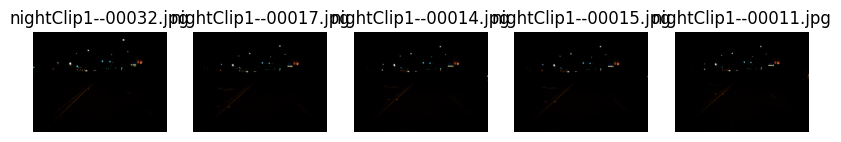

In [ ]:

# Example usage of the display function
# This helps in verifying that the images are loaded correctly
#ready for furt processing and model training
image_files = os.listdir(image_folder_path)
display_images(image_folder_path, image_files)


In [ ]:


    # Create an empty image (black image) with the size 64x64 pixels and 3 color channels (RGB)
img_array = np.zeros((64, 64, 3))

# Expand the dimensions of the image array to add a batch dimension (required by the model)
img_array = np.expand_dims(img_array, axis=0)

# Use the trained model to predict the probability that the image is "go"
prediction = model.predict(img_array)

# Print the predicted probability for the "go" class
print(f'Probability of "go": {prediction[0][0]}')

# Define the threshold for classification
threshold = 0.5

# Compare the predicted probability with the threshold to classify the image
if prediction[0][0] > threshold:
    print("The image is classified as 'go'")  # If the probability is greater than 0.5, classify as "go"
else:
    print("The image is classified as 'not go'")  # If the probability is 0.5 or less, classify as "not go"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Probability of "go": 0.4742961823940277
The image is classified as 'not go'


In [ ]:
import os


archive_path = '/content/drive/My Drive/archive-7/'

print("Contents of archive-7:")
print(os.listdir(archive_path))


day_train_path = os.path.join(archive_path, 'dayTrain/dayTrain/')
print("\nContents of dayTrain/dayTrain:")
print(os.listdir(day_train_path))

frames_path = os.path.join(day_train_path, 'dayClip4/frames/')
print("\nContents of dayClip4/frames:")
print(os.listdir(frames_path))


subfolder_path = os.path.join(sample_night_clip_path, 'sample-nightClip1/')
print("\nContents of sample-nightClip1/sample-nightClip1:")
print(os.listdir(subfolder_path))



Contents of archive-7:
['daySequence2', 'dayTrain', 'sample-dayClip6', 'Annotations', 'nightTrain', 'nightSequence1', 'daySequence1', 'nightSequence2', 'sample-nightClip1']

Contents of dayTrain/dayTrain:
['dayClip7', 'dayClip1', 'dayClip9', 'dayClip12', 'dayClip4', 'dayClip6', 'dayClip13', 'dayClip11', 'dayClip5', 'dayClip8', 'dayClip2', 'dayClip10', 'dayClip3']

Contents of dayClip4/frames:
[]

Contents of sample-nightClip1/sample-nightClip1:
['frameAnnotationsBULB.csv', 'frameAnnotationsBOX.csv', 'frames']


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np


img_path = '/content/drive/My Drive/archive-7/sample-nightClip1/sample-nightClip1/frames/nightClip1--00000.jpg'


img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0


prediction = model.predict(img_array)
print(f'Probability of "go": {prediction[0][0]}')


threshold = 0.5
if prediction[0][0] > threshold:
    print("The image is classified as 'go'")
else:
    print("The image is classified as 'not go'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Probability of "go": 0.46869832277297974
The image is classified as 'not go'


In [ ]:
model.save('traffic_sign_model.h5')